# Úkol č. 2 - předzpracování dat a binární klasifikace (do 2. listopadu 23:59)

  * V rámci tohoto úkolu se musíte vypořádat s příznaky, které jsou různých typů.
  * Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru **data.csv** a data na vyhodnocení v souboru **evaluation.csv**.

#### Seznam příznaků:
* survived - zda přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * V Jupyter notebooku načtěte data ze souboru **data.csv**. Vhodným způsobem si je rozdělte na podmnožiny vhodné k trénování modelu.
  * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
  * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména. Některé příznaky můžete také úplně zahodit.
  * Nějakým způsobem se vypořádejte s chybějícími hodnotami.
  * Následně si vyberte vhodný klasifikační model z přednášek. Najděte vhodné hyperparametry a určete jeho přesnost (accuracy) na trénovací množině. Také určete jeho přesnost na testovací množině.
  * Načtěte vyhodnocovací data ze souboru **evaluation.csv**. Napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte **results.csv** soubor, ve kterém tyto predikce uložíte do dvou sloupců: ID, predikce přežití. Tento soubor nahrajte do repozitáře.
  * Ukázka prvních řádků souboru *results.csv*:
  
```
ID,survived
1000,0
1001,1
...
```

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * (až +4 body) Aplikujte všechny klasifikační modely z přednášek a určete (na základě přesnosti na validační množině), který je nejlepší. Přesnost tohoto nejlepšího modelu odhadněte pomocí křížové validace. K predikcím na vyhodnocovacích datech využijte tento model.
  * (až +4 body) Zkuste použít nějaké (alespoň dvě) netriviální metody doplňování chybějících hodnot u věku. Zaměřte na vliv těchto metod na přesnost predikce výsledného modelu. K predikcím na vyhodnocovacích datech využijte ten přístup, který Vám vyjde jako nejlepší.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte nejen Jupyter Notebook, ale i _csv_ soubor s predikcemi pro vyhodnocovací data (`results.csv`).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import random

random_seed = 42
random.seed(random_seed)

## 1) Cteni a predzpracovani dat

In [2]:
data = pd.read_csv("./data.csv", index_col='ID')
data_eval = pd.read_csv('./evaluation.csv', index_col='ID')

data = pd.concat([data, data_eval])

display(data.info())
data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   survived   1000 non-null   float64
 1   pclass     1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  home.dest  745 non-null    object 
dtypes: float64(3), int64(3), object(6)
memory usage: 132.9+ KB


None

survived  pclass                                        name     sex  \
ID                                                                           
0          1.0       3                  Dorking, Mr. Edward Arthur    male   
1          1.0       2                   Smith, Miss. Marion Elsie  female   
2          0.0       3                Hegarty, Miss. Hanora "Nora"  female   
3          0.0       3                       Sage, Mr. John George    male   
4          0.0       3                         Cacic, Miss. Marija  female   
...        ...     ...                                         ...     ...   
1304       NaN       3                    Buckley, Miss. Katherine  female   
1305       NaN       3                               Bing, Mr. Lee    male   
1306       NaN       3                           Daher, Mr. Shedid    male   
1307       NaN       1  Wick, Mrs. George Dennick (Mary Hitchcock)  female   
1308       NaN       2                        Fynney, Mr. Joseph J    male   

       age  sibsp  parch      ticket      fare cabin embarked  \
ID                                                              
0     19.0      0      0  A/5. 10482    8.0500   NaN        S   
1     40.0      0      0       31418   13.0000   NaN        S   
2     18.0      0      0      365226    6.7500   NaN        Q   
3      NaN      1      9    CA. 2343   69.5500   NaN        S   
4     30.0      0      0      315084    8.6625   NaN        S   
...    ...    ...    ...         ...       ...   ...      ...   
1304  18.5      0      0      329944    7.2833   NaN        Q   
1305  32.0      0      0        1601   56.4958   NaN        S   
1306  22.5      0      0        2698    7.2250   NaN        C   
1307  45.0      1      1       36928  164.8667   NaN        S   
1308  35.0      0      0      239865   26.0000   NaN        S   

                         home.dest  
ID                                  
0              England Oglesby, IL  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  
...                            ...  
1304  Co Cork, Ireland Roxbury, MA  
1305        Hong Kong New York, NY  
1306                           NaN  
1307                Youngstown, OH  
1308      Liverpool / Montreal, PQ  

[1309 rows x 12 columns]

Zaprve, vidime, ze sloupec *cabin* obsahue skoro 78% chybejicich hodnot a navic bez planu kabin nedokazeme z tohoto priznaku vytezit nejake znalosti (stejne jako z priznaku ticket). Takze vyhodime oba priznaky.

Priznak *age* ma 80% nenulovych hodnot, takze to dokazeme imputovat.

V priznaku *home.dest* chybi skoro pulka hodnot, ale predpokladam, ze nastupni a vystupni stanice nebude mit vliv na preziti, takze vyhodime.

Priznak embarked ma jen 2 nulove hodnoty, takze se da smazat dva radky, ale je otazkou, jestli vubec ten priznak potrebueme.

ID taky nepotrebujeme

Priznak *name* jeste budeme potrebovat

In [3]:
columns_to_drop = ['ticket', 'cabin', 'home.dest']
data.drop(columns=columns_to_drop, inplace=True)

data

survived  pclass                                        name     sex  \
ID                                                                           
0          1.0       3                  Dorking, Mr. Edward Arthur    male   
1          1.0       2                   Smith, Miss. Marion Elsie  female   
2          0.0       3                Hegarty, Miss. Hanora "Nora"  female   
3          0.0       3                       Sage, Mr. John George    male   
4          0.0       3                         Cacic, Miss. Marija  female   
...        ...     ...                                         ...     ...   
1304       NaN       3                    Buckley, Miss. Katherine  female   
1305       NaN       3                               Bing, Mr. Lee    male   
1306       NaN       3                           Daher, Mr. Shedid    male   
1307       NaN       1  Wick, Mrs. George Dennick (Mary Hitchcock)  female   
1308       NaN       2                        Fynney, Mr. Joseph J    male   

       age  sibsp  parch      fare embarked  
ID                                           
0     19.0      0      0    8.0500        S  
1     40.0      0      0   13.0000        S  
2     18.0      0      0    6.7500        Q  
3      NaN      1      9   69.5500        S  
4     30.0      0      0    8.6625        S  
...    ...    ...    ...       ...      ...  
1304  18.5      0      0    7.2833        Q  
1305  32.0      0      0   56.4958        S  
1306  22.5      0      0    7.2250        C  
1307  45.0      1      1  164.8667        S  
1308  35.0      0      0   26.0000        S  

[1309 rows x 9 columns]

Ted zkusime doplnit chybejici hodnoty priznaku *age*. Budeme to delat tak, ze udelame priznak *title*, ktery vytahneme ze jmena (a pak priznak *name* vyhodim).
Pak spocitame median veku lidi seskupenene podle tridy a titulu a doplnime chybejici hodnoty veku prislusnym medianem. Median spocitejme na trenovaci mnozine, aby validacni data neovlivnovala model

In [4]:
data['title'] = data['name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

display(data)
data['title'].unique()

survived  pclass                                        name     sex  \
ID                                                                           
0          1.0       3                  Dorking, Mr. Edward Arthur    male   
1          1.0       2                   Smith, Miss. Marion Elsie  female   
2          0.0       3                Hegarty, Miss. Hanora "Nora"  female   
3          0.0       3                       Sage, Mr. John George    male   
4          0.0       3                         Cacic, Miss. Marija  female   
...        ...     ...                                         ...     ...   
1304       NaN       3                    Buckley, Miss. Katherine  female   
1305       NaN       3                               Bing, Mr. Lee    male   
1306       NaN       3                           Daher, Mr. Shedid    male   
1307       NaN       1  Wick, Mrs. George Dennick (Mary Hitchcock)  female   
1308       NaN       2                        Fynney, Mr. Joseph J    male   

       age  sibsp  parch      fare embarked title  
ID                                                 
0     19.0      0      0    8.0500        S    Mr  
1     40.0      0      0   13.0000        S  Miss  
2     18.0      0      0    6.7500        Q  Miss  
3      NaN      1      9   69.5500        S    Mr  
4     30.0      0      0    8.6625        S  Miss  
...    ...    ...    ...       ...      ...   ...  
1304  18.5      0      0    7.2833        Q  Miss  
1305  32.0      0      0   56.4958        S    Mr  
1306  22.5      0      0    7.2250        C    Mr  
1307  45.0      1      1  164.8667        S   Mrs  
1308  35.0      0      0   26.0000        S    Mr  

[1309 rows x 10 columns]

array(['Mr', 'Miss', 'Mrs', 'Master', 'Rev', 'Major', 'Dr', 'Ms',
       'Jonkheer', 'the Countess', 'Col', 'Mme', 'Capt', 'Mlle', 'Sir',
       'Don', 'Lady', 'Dona'], dtype=object)

In [5]:
median_age = data.iloc[:1000, :].groupby(['pclass', 'title'])['age'].median()

median_age

pclass  title       
1       Col             56.0
        Dr              50.0
        Jonkheer        38.0
        Major           48.5
        Master           4.0
        Miss            30.0
        Mme             24.0
        Mr              39.5
        Mrs             45.0
        the Countess    33.0
2       Dr              23.0
        Master           1.5
        Miss            20.0
        Mr              29.0
        Mrs             30.0
        Ms              28.0
        Rev             42.0
3       Master           4.5
        Miss            18.0
        Mr              26.0
        Mrs             32.0
        Ms               NaN
Name: age, dtype: float64

Bohuzel, vidime, ze v 3. tride zadna Ms nema vyplneny vek, proto vyplnime tu hodnotu medianem veku Ms z druhe tridy

In [6]:
median_age.replace(np.nan, median_age.at[(2, 'Ms')], inplace=True)
median_age

pclass  title       
1       Col             56.0
        Dr              50.0
        Jonkheer        38.0
        Major           48.5
        Master           4.0
        Miss            30.0
        Mme             24.0
        Mr              39.5
        Mrs             45.0
        the Countess    33.0
2       Dr              23.0
        Master           1.5
        Miss            20.0
        Mr              29.0
        Mrs             30.0
        Ms              28.0
        Rev             42.0
3       Master           4.5
        Miss            18.0
        Mr              26.0
        Mrs             32.0
        Ms              28.0
Name: age, dtype: float64

In [7]:
for pclass, title in median_age.index:
    data.loc[(data.age.isnull()) & (data.pclass == pclass) & (data.title == title), 'age'] = median_age.at[(pclass, title)] 

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  1000 non-null   float64
 1   pclass    1309 non-null   int64  
 2   name      1309 non-null   object 
 3   sex       1309 non-null   object 
 4   age       1309 non-null   float64
 5   sibsp     1309 non-null   int64  
 6   parch     1309 non-null   int64  
 7   fare      1308 non-null   float64
 8   embarked  1307 non-null   object 
 9   title     1309 non-null   object 
dtypes: float64(3), int64(3), object(4)
memory usage: 112.5+ KB


Zbavili jsme se chybejicich hodnot, ted musime zakodovat kategoricke priznaky

In [8]:
data.select_dtypes('object')

name     sex embarked title
ID                                                                     
0                     Dorking, Mr. Edward Arthur    male        S    Mr
1                      Smith, Miss. Marion Elsie  female        S  Miss
2                   Hegarty, Miss. Hanora "Nora"  female        Q  Miss
3                          Sage, Mr. John George    male        S    Mr
4                            Cacic, Miss. Marija  female        S  Miss
...                                          ...     ...      ...   ...
1304                    Buckley, Miss. Katherine  female        Q  Miss
1305                               Bing, Mr. Lee    male        S    Mr
1306                           Daher, Mr. Shedid    male        C    Mr
1307  Wick, Mrs. George Dennick (Mary Hitchcock)  female        S   Mrs
1308                        Fynney, Mr. Joseph J    male        S    Mr

[1309 rows x 4 columns]

Kategorickymi priznaky jsou name, sex a title. Jmeno uz potrebovat nebudeme, predpokladejme, ze nema vliv na preziti. Titul nam take uz moc nerika, potrebovali jsme ho jen na doplneni chybejicich hodnot veku. Takze tech priznaku se zbavime.

Priznak sex je tzv dichotomicky (ma jen 2 hodnoty), takze ho snadno transformujeme do binarniho priznaku. 

Pomoci one-hot encodingu zakodujeme priznak embarked. 

In [9]:
columns_to_drop = ['name', 'title']
data = data.drop(columns=columns_to_drop)

# transformation of sex column
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'male' else 1)

# embarked column 
dummies = pd.get_dummies(data['embarked'])
data = pd.concat([data.drop(columns='embarked'), dummies], axis=1)

display(data.info())
data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  1000 non-null   float64
 1   pclass    1309 non-null   int64  
 2   sex       1309 non-null   int64  
 3   age       1309 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1308 non-null   float64
 7   C         1309 non-null   uint8  
 8   Q         1309 non-null   uint8  
 9   S         1309 non-null   uint8  
dtypes: float64(3), int64(4), uint8(3)
memory usage: 85.6 KB


None

survived  pclass  sex   age  sibsp  parch      fare  C  Q  S
ID                                                                
0          1.0       3    0  19.0      0      0    8.0500  0  0  1
1          1.0       2    1  40.0      0      0   13.0000  0  0  1
2          0.0       3    1  18.0      0      0    6.7500  0  1  0
3          0.0       3    0  26.0      1      9   69.5500  0  0  1
4          0.0       3    1  30.0      0      0    8.6625  0  0  1
...        ...     ...  ...   ...    ...    ...       ... .. .. ..
1304       NaN       3    1  18.5      0      0    7.2833  0  1  0
1305       NaN       3    0  32.0      0      0   56.4958  0  0  1
1306       NaN       3    0  22.5      0      0    7.2250  1  0  0
1307       NaN       1    1  45.0      1      1  164.8667  0  0  1
1308       NaN       2    0  35.0      0      0   26.0000  0  0  1

[1309 rows x 10 columns]

In [10]:
data['fare'] = data['fare'].fillna(data_eval['fare'].median())
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  1000 non-null   float64
 1   pclass    1309 non-null   int64  
 2   sex       1309 non-null   int64  
 3   age       1309 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1309 non-null   float64
 7   C         1309 non-null   uint8  
 8   Q         1309 non-null   uint8  
 9   S         1309 non-null   uint8  
dtypes: float64(3), int64(4), uint8(3)
memory usage: 85.6 KB


V evaluacni mnozine chybi jedna hodnota ceny listku, tak ji jednoduse doplnime medianem celeho sloupce. 
Data jsou pripravena k uceni a evaluaci

## 2) Uceni modelu
Na zacatku natrenujeme modely jednotlive a podivame se na jejich presnost. Pak pustime grid search s krizovou validacci a porovanme vysledky.   

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
data_eval = data.iloc[1000:].drop(columns='survived')
data = data.iloc[:1000]
data.astype({'survived': int})

X = data.drop(columns='survived')
y = data['survived']

X_eval = data_eval

In [13]:
# aplikujeme MinMax scaling na data, ktera pouzijeme na trenovani kNN 
scaler = MinMaxScaler()
X_knn = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

X_eval_knn = scaler.transform(X_eval)
X_eval_knn = pd.DataFrame(X_eval_knn, columns=X_eval.columns, index=X_eval.index)

In [14]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, train_size=0.8, random_state=random_seed)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, train_size=0.8, random_state=random_seed)

In [15]:
def get_best_params(model, parameter_grid, minmaxscale=False):
    parameter_comb = ParameterGrid(parameter_grid)
    results = []
    for comb in parameter_comb:
        if not minmaxscale:
            model_trained = model(**comb).fit(X_train, y_train)
        else:
            model_trained = model(**comb).fit(X_knn.iloc[X_train.index, :], y_train)
        results.append(accuracy_score(y_val, model_trained.predict(X_knn.iloc[X_val.index, :])))
    best_params = parameter_comb[np.argmax(results)]
    return best_params

#### 2.1) Decision tree

In [16]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score

In [17]:
parameter_grid_tree = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : range(2, 12)
}

best_params_tree = get_best_params(DecisionTreeClassifier, parameter_grid_tree)
best_params_tree

{'max_depth': 4, 'criterion': 'gini'}

In [18]:
best_tree = DecisionTreeClassifier(**best_params_tree).fit(X_train, y_train)
y_pred_train = best_tree.predict(X_train)
y_pred_test = best_tree.predict(X_test)
print(f'Train accuracy = {accuracy_score(y_train, y_pred_train):.3}')
print(f'Test accuracy = {accuracy_score(y_test, y_pred_test):.3}')

Train accuracy = 0.827
Test accuracy = 0.745


#### 2.2) Random forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
parameter_grid_forest = {
    'criterion' : ['gini', 'entropy'],
    'n_estimators': range(5, 100, 2),
    'max_depth' : range(2, 12)
}

best_params_forest = get_best_params(RandomForestClassifier, parameter_grid_forest)
best_params_forest

{'n_estimators': 47, 'max_depth': 10, 'criterion': 'gini'}

In [21]:
best_forest = RandomForestClassifier(**best_params_forest).fit(X_train, y_train)
y_pred_train = best_forest.predict(X_train)
y_pred_test = best_forest.predict(X_test)
print(f'Train accuracy = {accuracy_score(y_train, y_pred_train):.3}')
print(f'Test accuracy = {accuracy_score(y_test, y_pred_test):.3}')

Train accuracy = 0.934
Test accuracy = 0.805


#### 2.3) Ada-boost 

In [22]:
from sklearn.ensemble import AdaBoostClassifier

In [23]:
parameter_grid_ada = {
    'learning_rate' : [0.01, 0.03, 0.1, 0.3, 0.8, 1, 2, 3],
    'n_estimators': range(5, 100, 2)
}

best_params_ada = get_best_params(AdaBoostClassifier, parameter_grid_ada)
best_params_ada

{'n_estimators': 5, 'learning_rate': 0.01}

In [24]:
best_ada = AdaBoostClassifier(**best_params_ada).fit(X_train, y_train)
y_pred_train = best_ada.predict(X_train)
y_pred_test = best_ada.predict(X_test)
print(f'Train accuracy = {accuracy_score(y_train, y_pred_train):.3}')
print(f'Test accuracy = {accuracy_score(y_test, y_pred_test):.3}')

Train accuracy = 0.75
Test accuracy = 0.8


#### 2.4) kNN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
pararmeter_grid_knn = {
    'n_neighbors': range(1, 15),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    
}

best_params_knn = get_best_params(KNeighborsClassifier, pararmeter_grid_knn, minmaxscale=True)
best_params_knn

{'weights': 'uniform', 'p': 2, 'n_neighbors': 7}

In [27]:
best_knn = KNeighborsClassifier(**best_params_knn).fit(X_knn.iloc[X_train.index, :], y_train)
y_pred_train = best_knn.predict(X_knn.iloc[X_train.index, :])
y_pred_test = best_knn.predict(X_test)
print(f'Train accuracy = {accuracy_score(y_train, y_pred_train):.3}')
print(f'Test accuracy = {accuracy_score(y_test, y_pred_test):.3}')

Train accuracy = 0.82
Test accuracy = 0.7


#### 2.5) Naive Bayes
Zvolil jsem MOntinomialniho Naivniho Bayese kvuli tome, ze tostovaci sada obsahuje diskretni a spojite priznaky.

In [28]:
from sklearn.naive_bayes import MultinomialNB

In [30]:
parameter_grid_NB ={
    'alpha': range(1, 10)
}

best_params_NB = get_best_params(MultinomialNB, parameter_grid_NB)
best_params_NB

{'alpha': 1}

In [31]:
best_NB = MultinomialNB(**best_params_NB).fit(X_train, y_train)
y_pred_train = best_NB.predict(X_train)
y_pred_test = best_NB.predict(X_test)
print(f'Train accuracy = {accuracy_score(y_train, y_pred_train):.3}')
print(f'Test accuracy = {accuracy_score(y_test, y_pred_test):.3}')

Train accuracy = 0.673
Test accuracy = 0.71


### Best model
na zaklade techto udaju vidime, ze nejlepsim modelem zatim je AdaBoostClassifier s 5 estimatory a learning rate 0.01

In [32]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

In [33]:
models = [
    DecisionTreeClassifier(random_state=random_seed),
    RandomForestClassifier(random_state=random_seed),
    AdaBoostClassifier(random_state=random_seed),
    MultinomialNB()
]

grid = {
    'DecisionTreeClassifier': parameter_grid_tree,
    'RandomForestClassifier': parameter_grid_forest,
    'AdaBoostClassifier': parameter_grid_ada,
    'MultinomialNB': parameter_grid_NB
}

scores = {}
for model in tqdm(models, position=0):
    search = GridSearchCV(estimator=model, 
                          param_grid=grid[model.__class__.__name__],
                          scoring='accuracy',
                          cv=5)
    search.fit(X_train_full, y_train_full)
    scores[search.best_score_] = search


100%|██████████| 4/4 [10:16<00:00, 154.01s/it]


In [34]:
search = GridSearchCV(estimator=KNeighborsClassifier(),
                      param_grid=pararmeter_grid_knn,
                      scoring='accuracy',
                      cv=5)
search.fit(X_knn.iloc[X_train_full.index, :], y_train_full)
scores[search.best_score_] = search

In [35]:
scores

{0.80375: GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_depth': range(2, 12)},
              scoring='accuracy'),
 0.8125: GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
              param_grid={'criterion': ['gini', 'entropy'],
                          'max_depth': range(2, 12),
                          'n_estimators': range(5, 100, 2)},
              scoring='accuracy'),
 0.78125: GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
              param_grid={'learning_rate': [0.01, 0.03, 0.1, 0.3, 0.8, 1, 2, 3],
                          'n_estimators': range(5, 100, 2)},
              scoring='accuracy'),
 0.67: GridSearchCV(cv=5, estimator=MultinomialNB(),
              param_grid={'alpha': range(1, 10)}, scoring='accuracy'),
 0.8: GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
              param_grid={'n_neighbors': range(

Vidime, ze train accuracy se zmenila. Ted zkontrolujeme test accuracy  

In [36]:
test_acc = []
for model in scores.values():
    best_model_CV = model.best_estimator_
    if best_model_CV.__class__.__name__ != 'KNeighborsClassifier':
        y_pred_test = best_model_CV.predict(X_test)
    else:
        y_pred_test = best_model_CV.predict(X_knn.iloc[X_test.index, :])
    test_acc.append(accuracy_score(y_test, y_pred_test))
    print(f'Test accuracy {best_model_CV.__class__.__name__} = {test_acc[-1]:.3}')

Test accuracy DecisionTreeClassifier = 0.82
Test accuracy RandomForestClassifier = 0.795
Test accuracy AdaBoostClassifier = 0.785
Test accuracy MultinomialNB = 0.705
Test accuracy KNeighborsClassifier = 0.775


Testovaci presnost naopak v prumeru stoupla a nejlepsim modelem stale je rozhodovaci strom s testovaci presnosti 82%. 

In [37]:
final_model = list(scores.values())[np.argmax(test_acc)].best_estimator_
final_model

DecisionTreeClassifier(max_depth=3, random_state=42)

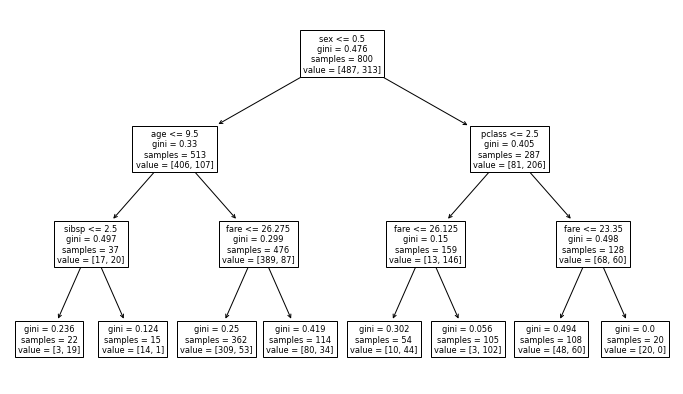

In [38]:
plt.figure(figsize=(12, 7))
plot_tree(final_model, feature_names=X.columns);

In [39]:
y_pred = final_model.predict(data_eval)
results = pd.DataFrame(y_pred, index=data_eval.index, columns=['survived']).astype(int)

In [40]:
results.to_csv('./results.csv')